<a href="https://colab.research.google.com/github/vgonzalez95/markowitz-implementation/blob/main/Markowitz_model_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set()

In [ ]:
def get_df(ticker):
  endpoint = f'https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?serietype=line&apikey=fdc87acc05b63069ece12db7d63a9541'
  x = requests.get(endpoint).json().get('historical')
  df = pd.DataFrame(x)
  df['date'] = pd.to_datetime(df['date'])
  df.rename(columns={'close': ticker}, inplace=True)
  df.set_index('date', inplace=True)
  return df

In [ ]:
def get_full_df(tickers):
  return pd.concat([get_df(t) for t in tickers], axis=1).dropna()

#### En esta celda se definen los tickers que conforman nuestro portafolio

In [ ]:
tickers = ['LNG', 'SPY','AMZN', 'GOOG']
full_df = get_full_df(tickers)

In [ ]:
# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()

In [ ]:
# returns_daily.hist(bins=10)

In [ ]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           LNG       SPY      AMZN      GOOG
LNG   0.000642 -0.000151 -0.000222 -0.000038
SPY  -0.000151  0.000194  0.000243  0.000226
AMZN -0.000222  0.000243  0.000443  0.000362
GOOG -0.000038  0.000226  0.000362  0.000560


In [ ]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(10000):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(round(returns,4))
        portfolio_volatility.setdefault(date, []).append(round(volatility,4))
        portfolio_weights.setdefault(date, []).append(np.round(weights, decimals=4))
        
print(portfolio_weights[date][0])

[0.0667 0.2214 0.3911 0.3208]


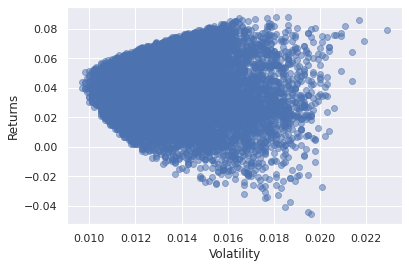

In [ ]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.5)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [ ]:
np_portfolio_volatility = np.array(portfolio_volatility[date])

In [ ]:
combined = {'volatility':portfolio_volatility[date], 'returns':portfolio_returns[date], 'weights':portfolio_weights[date]}

In [ ]:
combined_df = pd.DataFrame(combined)
combined_df.sort_values(by=['volatility', 'returns'], ascending=[True,False], inplace=True)
combined_df.drop_duplicates(subset=['volatility'], keep='first', inplace=True)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


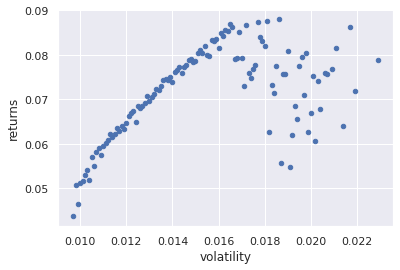

In [ ]:
combined_df[tickers] = pd.DataFrame(combined_df.weights.to_list(), index=combined_df.index)
combined_df.drop('weights',axis=1, inplace=True)
combined_df.plot.scatter(x='volatility', y ='returns')

In [ ]:
combined_df

,volatility,returns,LNG,SPY,AMZN,GOOG
2221,0.0097,0.0437,0.3286,0.5863,0.0737,0.0115
2315,0.0098,0.0507,0.2909,0.6436,0.0100,0.0556
1855,0.0099,0.0466,0.3480,0.5506,0.0663,0.0351
2892,0.0100,0.0513,0.3838,0.5719,0.0242,0.0200
3668,0.0101,0.0517,0.4044,0.5577,0.0247,0.0132
...,...,...,...,...,...,...
981,0.0211,0.0815,0.0634,0.0335,0.0670,0.8362
2936,0.0214,0.0641,0.0142,0.0392,0.1829,0.7637
5389,0.0217,0.0862,0.0074,0.1222,0.0079,0.8624
7716,0.0219,0.0718,0.0056,0.0455,0.1311,0.8178


In [ ]:
# from google.colab import files
# files.download('combined.csv')